## US Airlines Tweets Sentiment Analysis.

Sentiment Analysis is the process of determining whether a piece of writing is positive, negative or neutral. It’s also known as opinion mining, deriving the opinion or attitude of a speaker. A common use case for this technology is to discover how people feel about a particular topic.
In this notebook we will analyze how US Air Travellers expressed their feeling about US Airlines through Twitter in February 2015 by analyzing a series of Tweets.

### Importing Data

In [1]:
import pandas as pd
import numpy as np
import re
import collections

In [2]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

The data can be downloaded from Kaggle using this [link](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)

In [3]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Since we are dealing with Sentiment analysis, we are only concerned with the Tweets and the corresponding labels

In [4]:
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
12167,@AmericanAir I'm frustrated by all of the @USA...,negative
7285,@JetBlue you just tight that you're #59 on the...,neutral
10798,@USAirways another squashed flight. Having to ...,negative
9319,@USAirways do you operate ANY flights without ...,negative
1412,@united bags left behind because plane overwe...,negative


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords

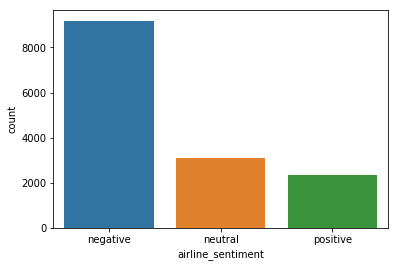

In [6]:
sns.countplot(x='airline_sentiment', data=df)

Run this step only if you don't have the stopwords downloaded from the nltk corpus

In [12]:
#import nltk
#nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jinudaniel74/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Data Pre Processing

A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. So in our tweets analysis we want to remove these stop words as these dont provide any meaningful insights to the feelings of the user.
We also want to get rid of the mentions.

In [7]:
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()

,text,airline_sentiment
12167,I'm frustrated attitude toward #ExecPlat mem...,negative
7285,tight #59 world's best airlines list &amp; r...,neutral
10798,another squashed flight. Having share seat an...,negative
9319,operate ANY flights without maintenance issue...,negative
1412,"bags left behind plane overweight, great knew...",negative


In [8]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

/home/jinudaniel74/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('Training Data:', X_train.shape[0])
print('Test Data:', X_test.shape[0])

Training Data: 13176
Test Data: 1464


Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation. 
So if we have an input word "Countrymen, lend me your ears" so after tokenization we get the following output.
`['Countrymen',['lend'],['your'],['ears']]`
Keras has an method `Tokenizer` which will help meet our requirement.

In [10]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Top 5 most common words are: [('flight', 3531), ('not', 1404), ('no', 1336), ('get', 1184), ('t', 1111)]


In [15]:
word_index = tk.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13974 unique tokens.


After having created the dictionary we can convert the text to a list of integer indexes. This is done with the `text_to_sequences` method of the Tokenizer.

In [16]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [17]:
print('{} -- is converted to -- {}'.format(X_train[5], X_train_seq[5]))

 seriously would pay $30 flight seats playing. really bad thing flying VA -- is converted to -- [286, 87, 2, 2910, 861, 1110, 16, 406, 35, 1, 2911, 4287, 4288, 4289, 2554, 376, 6054]


In [18]:
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()

count    13176.000000
mean        11.144961
std          4.214254
min          1.000000
25%          8.000000
50%         12.000000
75%         14.000000
max         24.000000
Name: text, dtype: float64

In [19]:
from keras.preprocessing.sequence import pad_sequences

In [20]:
MAX_LEN = 24
X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [21]:
print('{} -- is converted to -- {}'.format(X_train_seq[5], X_train_seq_trunc[5]))

[286, 87, 2, 2910, 861, 1110, 16, 406, 35, 1, 2911, 4287, 4288, 4289, 2554, 376, 6054] -- is converted to -- [   0    0    0    0    0    0    0  286   87    2 2910  861 1110   16
  406   35    1 2911 4287 4288 4289 2554  376 6054]


In [22]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [23]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

print('Shape of train set:',X_train_emb.shape)
print('Shape of validation set:',X_valid_emb.shape)

Shape of train set: (11858, 24)
Shape of validation set: (1318, 24)


### Training with LSTM

The network starts with an embedding layer. The layer lets the system expand each token to a more massive vector, allowing the network to represent a word in a meaningful way. Then will apply an LSTM layer with 64 units. We will also apply dropout to reduce overfitting. The final layer will be a Dense layer with 3 outputs as we have 3 labels in our dataset with softmax activation

In [24]:
from keras import models
from keras import layers

In [25]:
model = models.Sequential()
model.add(layers.Embedding(NB_WORDS, 8, input_length=MAX_LEN))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
history = model.fit(X_train_emb, y_train_emb, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_valid_emb, y_valid_emb))

Train on 11858 samples, validate on 1318 samples
Epoch 1/20
11858/11858 [==============================] - 22s 2ms/step - loss: 1.0184 - acc: 0.6093 - val_loss: 0.9028 - val_acc: 0.6426
Epoch 2/20
11858/11858 [==============================] - 1s 95us/step - loss: 0.9078 - acc: 0.6199 - val_loss: 0.8447 - val_acc: 0.6426
Epoch 3/20
11858/11858 [==============================] - 1s 95us/step - loss: 0.8087 - acc: 0.6325 - val_loss: 0.7486 - val_acc: 0.6844
Epoch 4/20
11858/11858 [==============================] - 1s 97us/step - loss: 0.7161 - acc: 0.6691 - val_loss: 0.6839 - val_acc: 0.7003
Epoch 5/20
11858/11858 [==============================] - 1s 97us/step - loss: 0.6300 - acc: 0.7134 - val_loss: 0.6450 - val_acc: 0.6988
Epoch 6/20
11858/11858 [==============================] - 1s 97us/step - loss: 0.5625 - acc: 0.7441 - val_loss: 0.6368 - val_acc: 0.7314
Epoch 7/20
11858/11858 [==============================] - 1s 96us/step - loss: 0.5127 - acc: 0.7692 - val_loss: 0.6228 - val_acc:

As you see the model trains fine but it starts overfitting on the training set. The below loss curve depicts this trend

In [27]:
def plot(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, EPOCHS + 1)

    plt.plot(e, metric, 'ro', label='Training ' + metric_name)
    plt.plot(e, val_metric, 'r', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

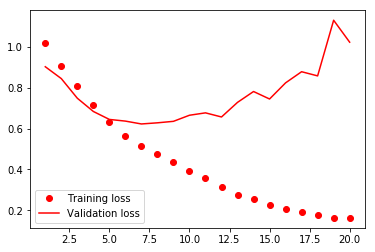

In [28]:
plot(history, 'loss')

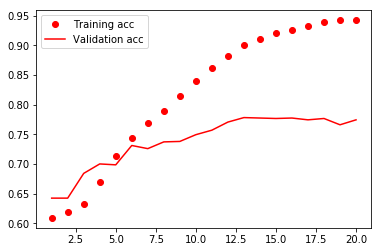

In [29]:
plot(history, 'acc')

In [30]:
test_model = model.evaluate(X_test_seq_trunc, y_test_oh)

1464/1464 [==============================] - 0s 341us/step


In [31]:
print('Test accuracy is {0:.2f}%'.format(test_model[1] * 100))

Test accuracy is 79.17%


### Use pre-trained Glove word embeddings

In this subsection, I want to use word embeddings from pre-trained Glove. It was trained on a dataset of one billion tokens (words) with a vocabulary of 400 thousand words. The glove has embedding vector sizes, including 50, 100, 200 and 300 dimensions. I chose the 100-dimensional version. The trained model can be downloaded from [here](https://nlp.stanford.edu/projects/glove/)


In [32]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [33]:
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [45]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(len(word_index) + 1, 100, input_length=MAX_LEN, weights=[embedding_matrix],trainable=False))
glove_model.add(layers.LSTM(400))
glove_model.add(layers.Dropout(0.2))
glove_model.add(layers.Dense(3, activation='softmax'))
glove_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 24, 100)           1397500   
_________________________________________________________________
lstm_5 (LSTM)                (None, 400)               801600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 1203      
Total params: 2,200,303
Trainable params: 802,803
Non-trainable params: 1,397,500
_________________________________________________________________


In [46]:
glove_history = model.fit(X_train_emb, y_train_emb, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                          validation_data=(X_valid_emb, y_valid_emb))

Train on 11858 samples, validate on 1318 samples
Epoch 1/20
11858/11858 [==============================] - 1s 123us/step - loss: 0.0379 - acc: 0.9877 - val_loss: 1.5957 - val_acc: 0.7443
Epoch 2/20
11858/11858 [==============================] - 1s 98us/step - loss: 0.0434 - acc: 0.9870 - val_loss: 1.7248 - val_acc: 0.7428
Epoch 3/20
11858/11858 [==============================] - 1s 96us/step - loss: 0.0418 - acc: 0.9865 - val_loss: 1.6789 - val_acc: 0.7451
Epoch 4/20
11858/11858 [==============================] - 1s 95us/step - loss: 0.0394 - acc: 0.9875 - val_loss: 1.6793 - val_acc: 0.7443
Epoch 5/20
11858/11858 [==============================] - 1s 96us/step - loss: 0.0362 - acc: 0.9883 - val_loss: 1.7074 - val_acc: 0.7420
Epoch 6/20
11858/11858 [==============================] - 1s 96us/step - loss: 0.0339 - acc: 0.9895 - val_loss: 1.7654 - val_acc: 0.7360
Epoch 7/20
11858/11858 [==============================] - 1s 96us/step - loss: 0.0328 - acc: 0.9893 - val_loss: 1.8473 - val_acc

If you see, model is heavily overfitted hence we have very high training accuracy but very poor validation accuracy.

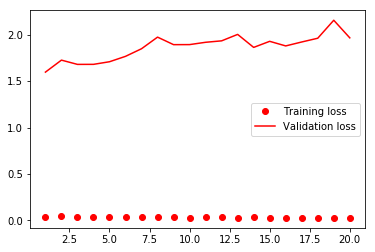

In [47]:
plot(glove_history, 'loss')

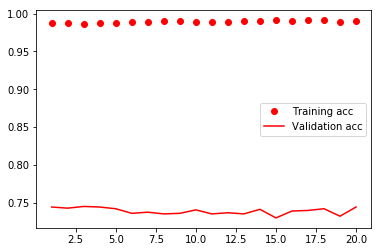

In [48]:
plot(glove_history, 'acc')

In [43]:
test_model = glove_model.evaluate(X_test_seq_trunc, y_test_oh)

1464/1464 [==============================] - 1s 485us/step


In [44]:
print('Test accuracy is {0:.2f}%'.format(test_model[1] * 100))

Test accuracy is 21.58%
